In [2]:
import requests
import zipfile
from pathlib import Path
import random
from PIL import Image
import numpy as np
import matplotlib.pylab as plt
import os
from typing import Tuple, Dict, List
from tqdm.auto import tqdm
from timeit import default_timer as timer 


from torch.utils.data import  DataLoader
from torchvision import datasets, transforms
import torch 
import torch.nn as nn
from torch.utils.data import Dataset
from torchinfo import summary

In [3]:
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        # print(self.paths)
        self.classes, self.class_to_idx = self.find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)
        
    def find_classes(self,directory:str)->Tuple[list[str],dict[str,int]]:
        classes=sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

        if not classes:
            raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
        class_to_idx={cls_name: i for i, cls_name in enumerate(classes)}
        
        print(classes,class_to_idx)
        return classes,class_to_idx


In [14]:
class CustomDataTest():
    def __init__(self) -> None:
        self.train_dir="C:\\Users\\Admin\\source\\repos\\deeplearn\\UnderstandingDeepLearning\\data\\pizza_steak_sushi\\train"
        self.test_dir="C:\\Users\\Admin\\source\\repos\\deeplearn\\UnderstandingDeepLearning\\data\\pizza_steak_sushi\\test"
        # self.train_dir = "C:\\Users\\Jakub Machura\\source\\repos\\UnderstandingDeepLearning\\data\\pizza_steak_sushi\\train"
        # self.test_dir = "C:\\Users\\Jakub Machura\\source\\repos\\UnderstandingDeepLearning\\data\\pizza_steak_sushi\\test"
        """
            temp placement for of transform
        """
        self.train_transform=transforms.Compose([
            transforms.Resize(size=(64,64)),
            transforms.TrivialAugmentWide(num_magnitude_bins=31),
            transforms.ToTensor()
        ])
    
        self.test_transforms = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor()
        ])
    
        self.train_data_custom =ImageFolderCustom(self.train_dir,transform=self.train_transform)
        self.test_data_custom=ImageFolderCustom(self.test_dir,transform=self.test_transforms)
    
        """temp place for testing data"""    
        # Check for equality amongst our custom Dataset and ImageFolder Dataset
        # print((len(self.train_data_custom) == len(data.train_data)) & (len(self.test_data_custom) == len(data.test_data)))
        # print(self.train_data_custom.classes == data.train_data.classes)
        # print(self.train_data_custom.class_to_idx == data.train_data.class_to_idx)

        self.IntoDataLoaders()

    def IntoDataLoaders(self):
        BATCH_SIZE=32
        # NUM_WORKERS = os.cpu_count()
        NUM_WORKERS = 1

        # print(f"number of workers avalible {NUM_WORKERS}")
        self.train_dataloader= DataLoader(dataset=self.train_data_custom, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                    #  num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

        self.test_dataloader = DataLoader(dataset=self.test_data_custom, # use custom created test Dataset
                                    batch_size=BATCH_SIZE, 
                                    # num_workers=NUM_WORKERS, 
                                    shuffle=False) # don't usually need to shuffle testing data

        img,label=next(iter(self.test_dataloader))
        # print(f"shape of custome dataloader img {img.shape}")

TinnyVGG with no regularization method applied

In [15]:
def train_step(model,loss_fn,optimizer,data):
        model.train()

        train_loss,train_acc=0, 0

        for batch, (X,y) in enumerate(data.train_dataloader):
            y_logits=model(X)

            loss=loss_fn(y_logits,y)
            train_loss+=loss.item()

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            y_pred_class = y_logits.argmax(dim=1)
            train_acc += (y_pred_class == y).sum().item()/len(y_pred_class)

        train_loss=train_loss/len(data.train_dataloader)
        train_acc=train_loss/len(data.train_dataloader)
        return train_loss,train_acc
    
def test_step(model,loss_fn,data:CustomDataTest):
    
    model.eval()
    test_loss,test_acc=0,0
    with torch.inference_mode():
        for batch, (X,y) in enumerate(data.test_dataloader):

            y_logits=model(X)

            loss=loss_fn(y_logits,y)
            test_loss+=loss.item()

            test_pred_labels = y_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss=test_loss/len(data.test_dataloader)
    test_acc=test_acc/len(data.test_dataloader)
    return test_loss, test_acc

def Totrain(model,data:CustomDataTest,epochs:int,optimizer,loss_fn:torch.nn.Module):
        
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    

    for epoch in tqdm(range(epochs)):
        train_loss,train_acc=train_step(model,loss_fn,optimizer,data)
        test_loss,test_acc=test_step(model,loss_fn,data)
                # 4. Print out what's happening
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results

In [16]:
class TinnyVGG(nn.Module):
    def __init__(self,in_shape:int,out_shape:int,hidden_units:int) -> None:
        super().__init__()

        self.conv_block1=nn.Sequential(
            nn.Conv2d(in_channels=in_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,out_features=out_shape)
        )
        print(self.state_dict)
    def forward(self,x):
        return(self.classifier(self.conv_block_2(self.conv_block1(x))))
    
    def ShapeCheck(self,data:CustomDataTest):
        img_batch,label_batch=next(iter(data.test_dataloader))

        img_single,label_single=img_batch[0].unsqueeze(dim=0), label_batch[0]
        
        # print(f"single img shape {img_single.shape}")

        self.eval()
        with torch.inference_mode():
            y=self(img_single)

        # print(f"shape of output raw y\n{y.shape}")
        # print(f"output of pred label \n{torch.argmax(torch.softmax(y,dim=1),dim=1)}")
        # print(f"actual label \n{label_single}")
    
    # def train_step(self,loss_fn,optimizer,data):
    #     self.train()

    #     train_loss,train_acc=0, 0

    #     for batch, (X,y) in enumerate(data.train_dataloader):
    #         y_logits=self(X)

    #         loss=loss_fn(y_logits,y)
    #         train_loss+=loss.item()

    #         optimizer.zero_grad()

    #         loss.backward()

    #         optimizer.step()

    #         y_pred_class = y_logits.argmax(dim=1)
    #         train_acc += (y_pred_class == y).sum().item()/len(y_pred_class)

    #     train_loss=train_loss/len(data.train_dataloader)
    #     train_acc=train_loss/len(data.train_dataloader)
    #     return train_loss,train_acc
    
    # def test_step(self,loss_fn,data:CustomDataTest):
        
    #     self.eval()

    #     test_loss,test_acc=0,0

    #     with torch.inference_mode():
    #         for batch, (X,y) in enumerate(data.test_dataloader):
    #             y_logits=self(X)

    #             loss=loss_fn(y_logits,y)
    #             test_loss+=loss.item()

    #             test_pred_labels = y_logits.argmax(dim=1)
    #             test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))


    #     test_loss=test_loss/len(data.test_dataloader)
    #     test_acc=test_acc/len(data.test_dataloader)
    #     return test_loss, test_acc

    # def Totrain(self,data:CustomDataTest,epochs:int,optimizer,loss_fn:torch.nn.Module):
        
    #     self.results = {"train_loss": [],
    #     "train_acc": [],
    #     "test_loss": [],
    #     "test_acc": []
    # }
    

    #     for epoch in tqdm(range(epochs)):
    #         train_loss,train_acc=self.train_step(loss_fn,optimizer,data)

    #         test_loss,test_acc=self.test_step(loss_fn,data)

    #                 # 4. Print out what's happening
    #         print(
    #             f"Epoch: {epoch+1} | "
    #             f"train_loss: {train_loss:.4f} | "
    #             f"train_acc: {train_acc:.4f} | "
    #             f"test_loss: {test_loss:.4f} | "
    #             f"test_acc: {test_acc:.4f}"
    #         )
    
    #         # 5. Update results dictionary
    #         self.results["train_loss"].append(train_loss)
    #         self.results["train_acc"].append(train_acc)
    #         self.results["test_loss"].append(test_loss)
    #         self.results["test_acc"].append(test_acc)
        
    #     return self.results

In [17]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    # plt.show()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

['pizza', 'steak', 'sushi'] {'pizza': 0, 'steak': 1, 'sushi': 2}
['pizza', 'steak', 'sushi'] {'pizza': 0, 'steak': 1, 'sushi': 2}
<bound method Module.state_dict of TinnyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1280, out_features=3, bias=True)
  )
)>


  7%|▋         | 1/15 [00:06<01:27,  6.27s/it]

Epoch: 1 | train_loss: 1.0985 | train_acc: 0.1373 | test_loss: 1.1557 | test_acc: 0.1979


 13%|█▎        | 2/15 [00:07<00:44,  3.41s/it]

Epoch: 2 | train_loss: 1.1155 | train_acc: 0.1394 | test_loss: 1.1320 | test_acc: 0.1979


 20%|██        | 3/15 [00:09<00:30,  2.51s/it]

Epoch: 3 | train_loss: 1.1098 | train_acc: 0.1387 | test_loss: 1.0899 | test_acc: 0.5417


 27%|██▋       | 4/15 [00:10<00:22,  2.04s/it]

Epoch: 4 | train_loss: 1.0963 | train_acc: 0.1370 | test_loss: 1.0905 | test_acc: 0.2604


 33%|███▎      | 5/15 [00:11<00:17,  1.79s/it]

Epoch: 5 | train_loss: 1.1156 | train_acc: 0.1394 | test_loss: 1.1154 | test_acc: 0.2604


 40%|████      | 6/15 [00:13<00:14,  1.66s/it]

Epoch: 6 | train_loss: 1.1040 | train_acc: 0.1380 | test_loss: 1.1338 | test_acc: 0.2604


 47%|████▋     | 7/15 [00:14<00:12,  1.58s/it]

Epoch: 7 | train_loss: 1.0964 | train_acc: 0.1370 | test_loss: 1.1438 | test_acc: 0.1979


 53%|█████▎    | 8/15 [00:15<00:10,  1.52s/it]

Epoch: 8 | train_loss: 1.1197 | train_acc: 0.1400 | test_loss: 1.1445 | test_acc: 0.1979


 60%|██████    | 9/15 [00:17<00:08,  1.48s/it]

Epoch: 9 | train_loss: 1.0953 | train_acc: 0.1369 | test_loss: 1.1172 | test_acc: 0.1979


 67%|██████▋   | 10/15 [00:18<00:07,  1.48s/it]

Epoch: 10 | train_loss: 1.0941 | train_acc: 0.1368 | test_loss: 1.1134 | test_acc: 0.1979


 73%|███████▎  | 11/15 [00:20<00:05,  1.46s/it]

Epoch: 11 | train_loss: 1.0914 | train_acc: 0.1364 | test_loss: 1.1175 | test_acc: 0.1979


 80%|████████  | 12/15 [00:21<00:04,  1.42s/it]

Epoch: 12 | train_loss: 1.0890 | train_acc: 0.1361 | test_loss: 1.1257 | test_acc: 0.1979


 87%|████████▋ | 13/15 [00:23<00:02,  1.43s/it]

Epoch: 13 | train_loss: 1.0860 | train_acc: 0.1358 | test_loss: 1.1368 | test_acc: 0.1979


 93%|█████████▎| 14/15 [00:24<00:01,  1.41s/it]

Epoch: 14 | train_loss: 1.1188 | train_acc: 0.1399 | test_loss: 1.1441 | test_acc: 0.1979


100%|██████████| 15/15 [00:25<00:00,  1.72s/it]

Epoch: 15 | train_loss: 1.1072 | train_acc: 0.1384 | test_loss: 1.1153 | test_acc: 0.1979
Total training time: 25.867 seconds


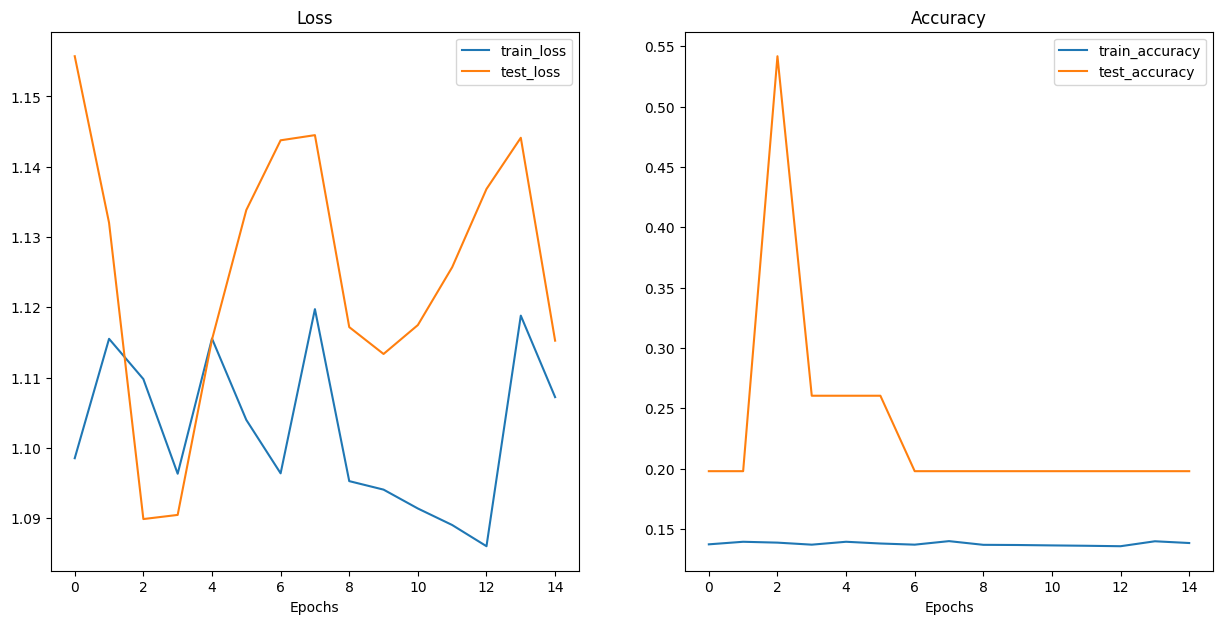

In [18]:

data1=CustomDataTest()
model0=TinnyVGG(3,len(data1.train_data_custom.classes),5)

model0_optimizer=torch.optim.Adam(params=model0.parameters(),lr=0.001)
model0_loss_fn=nn.CrossEntropyLoss()

start_time=timer()
model0_results=Totrain(model0,data=data1,epochs=15,optimizer=model0_optimizer,loss_fn=model0_loss_fn)

end_time=timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
plot_loss_curves(model0_results)

Model with 

In [19]:
class TinnyVGGNorm2D(nn.Module):
    def __init__(self,in_shape:int,out_shape:int,hidden_units:int) -> None:
        super().__init__()

        self.conv_block1=nn.Sequential(
            nn.Conv2d(in_channels=in_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.InstanceNorm2d(num_features=hidden_units,eps=1e-5,momentum=0.1,affine=True),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.InstanceNorm2d(num_features=hidden_units,eps=1e-5,momentum=0.1,affine=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*32*32,out_features=out_shape)
        )
        print(self.state_dict)
    def forward(self,x):
        return(self.classifier(self.conv_block1(x)))
    


<bound method Module.state_dict of TinnyVGGNorm2D(
  (conv_block1): Sequential(
    (0): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU()
    (3): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): InstanceNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5120, out_features=3, bias=True)
  )
)>


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:18,  1.61s/it]

Epoch: 1 | train_loss: 1.2401 | train_acc: 0.1550 | test_loss: 2.3668 | test_acc: 0.2812


  4%|▍         | 2/50 [00:02<01:10,  1.47s/it]

Epoch: 2 | train_loss: 1.1364 | train_acc: 0.1420 | test_loss: 1.3467 | test_acc: 0.3712


  6%|▌         | 3/50 [00:04<01:06,  1.42s/it]

Epoch: 3 | train_loss: 0.9322 | train_acc: 0.1165 | test_loss: 1.0145 | test_acc: 0.5256


  8%|▊         | 4/50 [00:05<01:06,  1.45s/it]

Epoch: 4 | train_loss: 0.8666 | train_acc: 0.1083 | test_loss: 1.0692 | test_acc: 0.4640


 10%|█         | 5/50 [00:07<01:03,  1.40s/it]

Epoch: 5 | train_loss: 0.8763 | train_acc: 0.1095 | test_loss: 1.5902 | test_acc: 0.2812


 12%|█▏        | 6/50 [00:08<01:00,  1.38s/it]

Epoch: 6 | train_loss: 0.8472 | train_acc: 0.1059 | test_loss: 1.2346 | test_acc: 0.3835


 14%|█▍        | 7/50 [00:09<00:59,  1.38s/it]

Epoch: 7 | train_loss: 0.8235 | train_acc: 0.1029 | test_loss: 1.1545 | test_acc: 0.3419


 16%|█▌        | 8/50 [00:11<00:57,  1.37s/it]

Epoch: 8 | train_loss: 0.6962 | train_acc: 0.0870 | test_loss: 1.1483 | test_acc: 0.4223


 18%|█▊        | 9/50 [00:12<00:56,  1.37s/it]

Epoch: 9 | train_loss: 0.8393 | train_acc: 0.1049 | test_loss: 1.4588 | test_acc: 0.3229


 20%|██        | 10/50 [00:13<00:54,  1.37s/it]

Epoch: 10 | train_loss: 0.7071 | train_acc: 0.0884 | test_loss: 1.0711 | test_acc: 0.6042


 22%|██▏       | 11/50 [00:15<00:54,  1.40s/it]

Epoch: 11 | train_loss: 0.7196 | train_acc: 0.0900 | test_loss: 1.7109 | test_acc: 0.3116


 24%|██▍       | 12/50 [00:16<00:54,  1.43s/it]

Epoch: 12 | train_loss: 0.9961 | train_acc: 0.1245 | test_loss: 1.4610 | test_acc: 0.4432


 26%|██▌       | 13/50 [00:18<00:53,  1.46s/it]

Epoch: 13 | train_loss: 0.9036 | train_acc: 0.1129 | test_loss: 1.7652 | test_acc: 0.2898


 28%|██▊       | 14/50 [00:19<00:53,  1.48s/it]

Epoch: 14 | train_loss: 0.8475 | train_acc: 0.1059 | test_loss: 1.2965 | test_acc: 0.4943


 30%|███       | 15/50 [00:21<00:50,  1.44s/it]

Epoch: 15 | train_loss: 0.7095 | train_acc: 0.0887 | test_loss: 1.6248 | test_acc: 0.3523


 32%|███▏      | 16/50 [00:22<00:49,  1.47s/it]

Epoch: 16 | train_loss: 0.7649 | train_acc: 0.0956 | test_loss: 1.1903 | test_acc: 0.5246


 34%|███▍      | 17/50 [00:24<00:47,  1.43s/it]

Epoch: 17 | train_loss: 0.6880 | train_acc: 0.0860 | test_loss: 1.7321 | test_acc: 0.3324


 36%|███▌      | 18/50 [00:25<00:45,  1.43s/it]

Epoch: 18 | train_loss: 0.7568 | train_acc: 0.0946 | test_loss: 1.2096 | test_acc: 0.4233


 38%|███▊      | 19/50 [00:26<00:43,  1.39s/it]

Epoch: 19 | train_loss: 0.4558 | train_acc: 0.0570 | test_loss: 1.3733 | test_acc: 0.3826


 40%|████      | 20/50 [00:28<00:40,  1.36s/it]

Epoch: 20 | train_loss: 0.5508 | train_acc: 0.0689 | test_loss: 1.8215 | test_acc: 0.3428


 42%|████▏     | 21/50 [00:29<00:39,  1.35s/it]

Epoch: 21 | train_loss: 0.6715 | train_acc: 0.0839 | test_loss: 1.3375 | test_acc: 0.5331


 44%|████▍     | 22/50 [00:30<00:38,  1.36s/it]

Epoch: 22 | train_loss: 0.7106 | train_acc: 0.0888 | test_loss: 2.1387 | test_acc: 0.3845


 46%|████▌     | 23/50 [00:32<00:36,  1.34s/it]

Epoch: 23 | train_loss: 0.6206 | train_acc: 0.0776 | test_loss: 1.1091 | test_acc: 0.5540


 48%|████▊     | 24/50 [00:33<00:37,  1.42s/it]

Epoch: 24 | train_loss: 0.6052 | train_acc: 0.0757 | test_loss: 1.8976 | test_acc: 0.3741


 50%|█████     | 25/50 [00:36<00:48,  1.94s/it]

Epoch: 25 | train_loss: 0.6377 | train_acc: 0.0797 | test_loss: 1.1263 | test_acc: 0.4934


 52%|█████▏    | 26/50 [00:40<01:00,  2.51s/it]

Epoch: 26 | train_loss: 0.5124 | train_acc: 0.0641 | test_loss: 1.6598 | test_acc: 0.4148


 54%|█████▍    | 27/50 [00:44<01:06,  2.87s/it]

Epoch: 27 | train_loss: 0.5986 | train_acc: 0.0748 | test_loss: 1.1515 | test_acc: 0.4545


 56%|█████▌    | 28/50 [00:48<01:09,  3.16s/it]

Epoch: 28 | train_loss: 0.4813 | train_acc: 0.0602 | test_loss: 1.4162 | test_acc: 0.4451


 58%|█████▊    | 29/50 [00:51<01:07,  3.22s/it]

Epoch: 29 | train_loss: 0.5905 | train_acc: 0.0738 | test_loss: 1.1096 | test_acc: 0.4943


 60%|██████    | 30/50 [00:55<01:06,  3.31s/it]

Epoch: 30 | train_loss: 1.0167 | train_acc: 0.1271 | test_loss: 2.1974 | test_acc: 0.3636


 62%|██████▏   | 31/50 [00:58<01:05,  3.44s/it]

Epoch: 31 | train_loss: 1.0145 | train_acc: 0.1268 | test_loss: 1.3800 | test_acc: 0.5133


 64%|██████▍   | 32/50 [01:02<01:03,  3.51s/it]

Epoch: 32 | train_loss: 0.8489 | train_acc: 0.1061 | test_loss: 1.7433 | test_acc: 0.4242


 66%|██████▌   | 33/50 [01:06<01:01,  3.63s/it]

Epoch: 33 | train_loss: 0.6554 | train_acc: 0.0819 | test_loss: 1.3707 | test_acc: 0.3920


 68%|██████▊   | 34/50 [01:10<00:59,  3.69s/it]

Epoch: 34 | train_loss: 0.5150 | train_acc: 0.0644 | test_loss: 1.2811 | test_acc: 0.4650


 70%|███████   | 35/50 [01:14<00:55,  3.68s/it]

Epoch: 35 | train_loss: 0.4354 | train_acc: 0.0544 | test_loss: 1.3469 | test_acc: 0.4034


 72%|███████▏  | 36/50 [01:17<00:52,  3.73s/it]

Epoch: 36 | train_loss: 0.6571 | train_acc: 0.0821 | test_loss: 1.2908 | test_acc: 0.4754


 74%|███████▍  | 37/50 [01:21<00:48,  3.76s/it]

Epoch: 37 | train_loss: 0.5695 | train_acc: 0.0712 | test_loss: 1.4968 | test_acc: 0.3939


 76%|███████▌  | 38/50 [01:25<00:45,  3.78s/it]

Epoch: 38 | train_loss: 0.7870 | train_acc: 0.0984 | test_loss: 1.2890 | test_acc: 0.5057


 78%|███████▊  | 39/50 [01:29<00:42,  3.82s/it]

Epoch: 39 | train_loss: 0.8244 | train_acc: 0.1031 | test_loss: 1.8480 | test_acc: 0.3939


 80%|████████  | 40/50 [01:33<00:38,  3.84s/it]

Epoch: 40 | train_loss: 0.5742 | train_acc: 0.0718 | test_loss: 1.3780 | test_acc: 0.4962


 82%|████████▏ | 41/50 [01:37<00:34,  3.87s/it]

Epoch: 41 | train_loss: 0.5175 | train_acc: 0.0647 | test_loss: 1.4957 | test_acc: 0.3835


 84%|████████▍ | 42/50 [01:41<00:30,  3.87s/it]

Epoch: 42 | train_loss: 0.3818 | train_acc: 0.0477 | test_loss: 1.2203 | test_acc: 0.4754


 86%|████████▌ | 43/50 [01:45<00:27,  3.86s/it]

Epoch: 43 | train_loss: 0.6825 | train_acc: 0.0853 | test_loss: 1.4766 | test_acc: 0.4858


 88%|████████▊ | 44/50 [01:48<00:23,  3.88s/it]

Epoch: 44 | train_loss: 0.5399 | train_acc: 0.0675 | test_loss: 1.2440 | test_acc: 0.5152


 90%|█████████ | 45/50 [01:52<00:19,  3.87s/it]

Epoch: 45 | train_loss: 0.6314 | train_acc: 0.0789 | test_loss: 1.7609 | test_acc: 0.4148


 92%|█████████▏| 46/50 [01:56<00:15,  3.87s/it]

Epoch: 46 | train_loss: 0.5279 | train_acc: 0.0660 | test_loss: 1.3133 | test_acc: 0.4025


 94%|█████████▍| 47/50 [02:00<00:11,  3.87s/it]

Epoch: 47 | train_loss: 0.4502 | train_acc: 0.0563 | test_loss: 1.4071 | test_acc: 0.3939


 96%|█████████▌| 48/50 [02:04<00:07,  3.86s/it]

Epoch: 48 | train_loss: 0.5570 | train_acc: 0.0696 | test_loss: 1.2525 | test_acc: 0.4138


 98%|█████████▊| 49/50 [02:08<00:03,  3.86s/it]

Epoch: 49 | train_loss: 0.4740 | train_acc: 0.0593 | test_loss: 1.4681 | test_acc: 0.3930


100%|██████████| 50/50 [02:12<00:00,  2.65s/it]

Epoch: 50 | train_loss: 0.4191 | train_acc: 0.0524 | test_loss: 1.4622 | test_acc: 0.3930
Total training time: 132.305 seconds


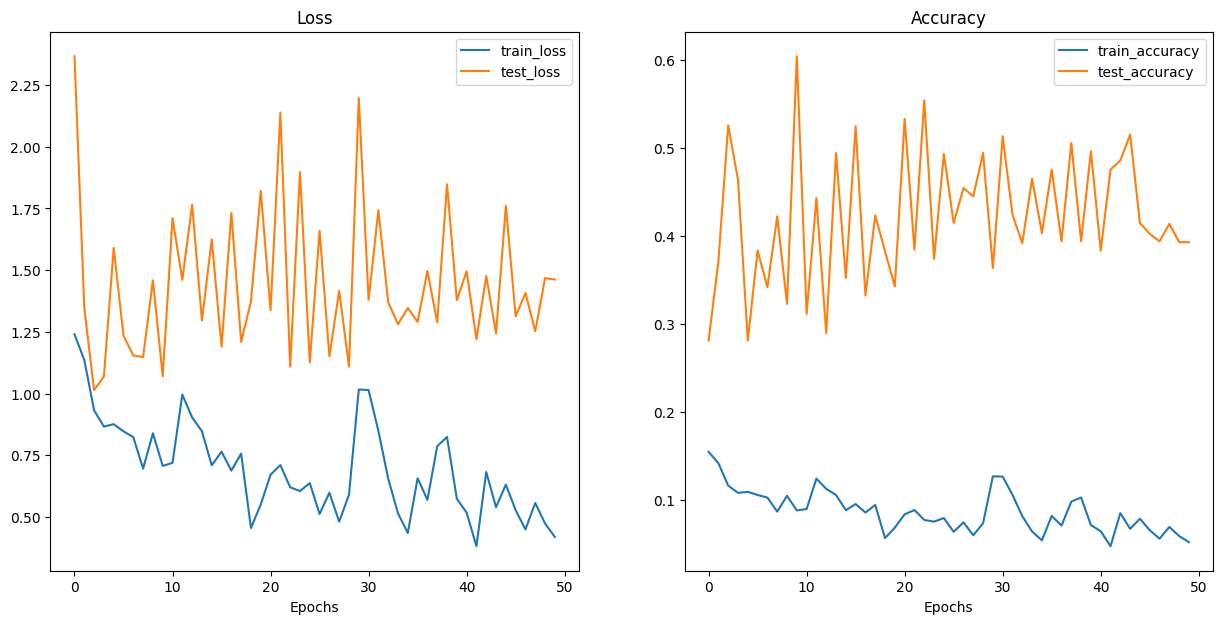

In [20]:
model1=TinnyVGGNorm2D(3,len(data1.train_data_custom.classes),5)

model1_optimizer=torch.optim.Adam(params=model1.parameters(),lr=0.001)
model1_loss_fn=nn.CrossEntropyLoss()

start_time=timer()
model1_results=Totrain(model1,data=data1,epochs=50,optimizer=model1_optimizer,loss_fn=model1_loss_fn)

end_time=timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
plot_loss_curves(model1_results)

Testing usage of BlockDrop on TinnyVGG with InstanceNorm2d regularization 
BlockDrop class 

In [21]:

class BlockDrop(nn.Module):
    def __init__(self, block, p=0.5):
        super(BlockDrop, self).__init__()
        self.block = block
        self.p = p

    def forward(self, x):
        if self.training:
            return self.block(x) if torch.rand(1) > self.p else x
        return self.block(x)

class TinnyVGGBlockDrop(nn.Module):
    def __init__(self,in_shape:int,out_shape:int,hidden_units:int) -> None:
        super().__init__()

        self.conv_block1=BlockDrop(nn.Sequential(
            nn.Conv2d(in_channels=in_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.InstanceNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.InstanceNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        ))
        self.conv_block_2 = BlockDrop(nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.InstanceNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.InstanceNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ))
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,out_features=out_shape)
        )
        print(self.state_dict)
    def forward(self,x):
        return(self.classifier(self.conv_block_2(self.conv_block1(x))))
    
    
   


In [22]:
# model2=TinnyVGGBlockDrop(3,len(data1.train_data_custom.classes),5)

# model2_optimizer=torch.optim.Adam(params=model2.parameters(),lr=0.001)
# model2_loss_fn=nn.CrossEntropyLoss()
# start_time=timer()

# model2_results=Totrain(model2,data=data1,epochs=50,optimizer=model2_optimizer,loss_fn=model2_loss_fn)

# end_time=timer()
# print(f"Total training time: {end_time-start_time:.3f} seconds")
# plot_loss_curves(model2_results)

<bound method Module.state_dict of TinnyVGGBlockDrop(
  (conv_block1): BlockDrop(
    (block): Sequential(
      (0): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(5, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU()
      (3): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(5, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv_block_2): BlockDrop(
    (block): Sequential(
      (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(5, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU()
      (3): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(5, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5)

  0%|          | 0/50 [00:01<?, ?it/s]


RuntimeError: Given groups=1, weight of size [5, 5, 3, 3], expected input[32, 3, 64, 64] to have 5 channels, but got 3 channels instead